In this notebook I'm going to analyse the tweet collected and the the most used hashtags by congolese on twitter
For now a simple defintion of a congolese on social media is someone who tweet using the following hashtags : DRC, RDC, RDCongo, DRCongo.

In [1]:
## Importing files from local directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from collections import Counter, defaultdict
import json
from scripts.mongo_db_client import get_tweets

Let analyse a tweet and get the hashtags involed in the tweet

In [3]:
def get_hashtags(tweet):
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])
    return [ get_text(tag) for tag in hashtags if get_text(tag) not in ['rdc', 'drc', 'rdcongo', 'drcongo']]

In [4]:
def get_text(tag):
    return tag.get('text').lower()

In [7]:
hastags = Counter()
for tweet in get_tweets('16-10-2019', '17-10-2019'):
    hashtags_in_tweet = get_hashtags(tweet)
    hastags.update(hashtags_in_tweet)
for tag,count in hastags.most_common(25):
    print("{} : {}".format(tag, count))

antonov : 62
goma : 37
nordkivu : 25
quota100 : 24
sudkivu : 21
crash : 19
cach : 14
burundi : 14
kinshasa : 13
ebola : 12
rwanda : 12
josephkabila : 11
congo : 11
ituri : 9
furrytails : 9
méditation : 9
happeningnow : 8
cameroun : 8
afrique : 7
histoire : 7
givingback : 7
agriculture : 7
sénat : 7
ouganda : 6
fhsrdc40 : 6


let check how our people uses others hastags apart from the one I selected 

In [8]:
hashtag_count = defaultdict(int)
for tweet in get_tweets('16-10-2019', '17-10-2019'):
    hashtags_in_tweet = get_hashtags(tweet)
    n_of_hashtags = len(hashtags_in_tweet)
    hashtag_count[n_of_hashtags] +=1
    tweet_with_hashtags = sum([count for n_of_tags , count in hashtag_count.items() if n_of_tags>0])
    tweet_without_hashtags = hashtag_count[0]
    total_tweet = tweet_with_hashtags + tweet_without_hashtags
print("{} tweets without hashtags  ({}%)".format(tweet_without_hashtags,  tweet_without_hashtags*100/total_tweet)) 
print("{} tweets with at least one hashtag  ({}%)".format(tweet_with_hashtags,  tweet_with_hashtags*100/total_tweet))        

1544 tweets without hashtags  (77.2%)
456 tweets with at least one hashtag  (22.8%)


Conclusion we can see that we have only 92 tweets without hashtags 

### II. Tweet text analysis

In this portion of the notebook we will analyse a tweet as text and perform some NLP tasks on it such tokenization, etc

In [9]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

In [10]:
def process_text(text, tokenizer= TweetTokenizer(), words_to_remove=[]):
    """
    Process the text of a tweet
    - lowertext
    - stop world 
    - digit removal
    and return a list of strings
    """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in words_to_remove and not token.isdigit()]
    

let do the analysis now

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/espoir_mur/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
punctuation  = list(string.punctuation)
stop_word_list_english = stopwords.words('english')
stop_word_list_french = stopwords.words('french')
others_words = ['rt', 'via', '...', '…', '»:', '«:' , '’:', 'les', '-', ]
words_to_remove = punctuation + stop_word_list_english + stop_word_list_french + others_words

In [15]:
term_counts = Counter()
for tweet in get_tweets('16-10-2019', '17-10-2019'):
    tokens = process_text(text=tweet.get('text'), words_to_remove=words_to_remove)
    term_counts.update(tokens)
for tag, count in term_counts.most_common(20):
    print("{}: {}".format(tag, count))

’: 517
#rdc: 470
rdc: 396
@presidence_rdc: 195
@fatshi13: 152
@soniarolley: 104
drc: 82
«: 80
🇨: 74
🇩: 74
@denisenyakeru: 72
contre: 71
e: 67
antonov: 67
président: 65
#antonov: 62
après: 59
da: 59
tout: 57
tshisekedi: 53


We can see that we need to update our list of stop words and punctuations world like '»:', '»:' , '’:' should be removed

For now we can remove them manually , and next time we will find a way to deal wit those kind of puctuation as weel as contractions

#### III. Term frequency

*The following graph will plot the term frequency of words vs his position within the ranking term*

In [16]:
y = [count for tag, count in term_counts.most_common(100)]
x = range(1, len(y)+1)

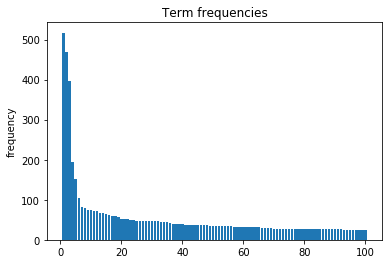

In [17]:
plt.bar(x, y)
plt.title("Term frequencies")
plt.ylabel('frequency')
plt.savefig('../images/term_distribution.png')

How can we explain this figure?
The figure shows a long tail, it can be explain with the fact the a small pottion of frequent item dominate the distribution, and . there is a large number of item with low frequency. This can also be explained as the **80-20** rule.

### III. Time series analysis 

Basically in this  section we will use the field `created_at` of a tweet and answer to this question:
**at what time congolese use twitter the most?**, the answer to this question can be usefull when we want to know when to tweet to reach a maximum audiance.

In [18]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

In [19]:
all_dates = list()
for tweet in get_tweets('16-10-2019', '17-10-2019'):
    all_dates.append(tweet.get('created_at'))
idx = pd.DatetimeIndex(all_dates)
ones = np.ones(len(idx))
one_second_series = pd.Series(ones, index=idx)

Downsample the series into 1 minute bins and sum the values of the timestamps falling into a bin.
Basically this helps us to know how many tweet we have in one minute time slot.

In [20]:
per_minute = one_second_series.resample('1Min').apply(sum).fillna(0)

2019-10-16 10:52:36 2019-10-16 08:03:04 the date are 


/Users/espoir_mur/Projects/Personnal/Twitter-Analysis-For-DRC/.venv/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 1224x1008 with 0 Axes>

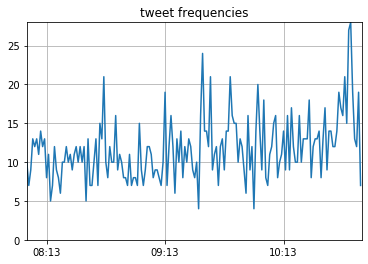

In [21]:
plt.figure(figsize=(17,14))
fig, ax=plt.subplots()
ax.grid(True)
ax.set_title('tweet frequencies')
hours = mdates.MinuteLocator(interval=60)
date_formatter = mdates.DateFormatter('%H:%M')
max_date = idx.max()
min_date = idx.min()
print(max_date, min_date, 'the date are ')
max_freq = per_minute.max()
ax.set_ylim(0,  max_freq)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlim(min_date, max_date)
ax.plot(per_minute.index, per_minute)
plt.savefig('../images/tweet_per_time.png')

We can see from the figure that our tweet were collected from a 30 minutes time intervales (18:00-18:30) and we have the pick time at 18:19 with more that 14 tweets.
Since our time slot was too small we can't find when congolese tweet a lot , but the procedure is set.
If we had more tweet we could estimate with accuracy when the congolese tweet the most and advice some buisness to tweet a lot in that time.

### IV. Create a WordCloud

A wordcloud is a image which looks like a cloud filled with word where the word size is proportional to the frequency of word in a list of words.

We can also say : 
WordCloud is a technique to show which words are the most frequent among the given text.

let install the package 

In [22]:
#!pip install WordCloud

In [23]:
from wordcloud import WordCloud
import matplotlib.colors as colors

we will use our `term_count`counter to generate the world cloud 

In [24]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',normalize_plurals=True).generate_from_frequencies(term_counts)

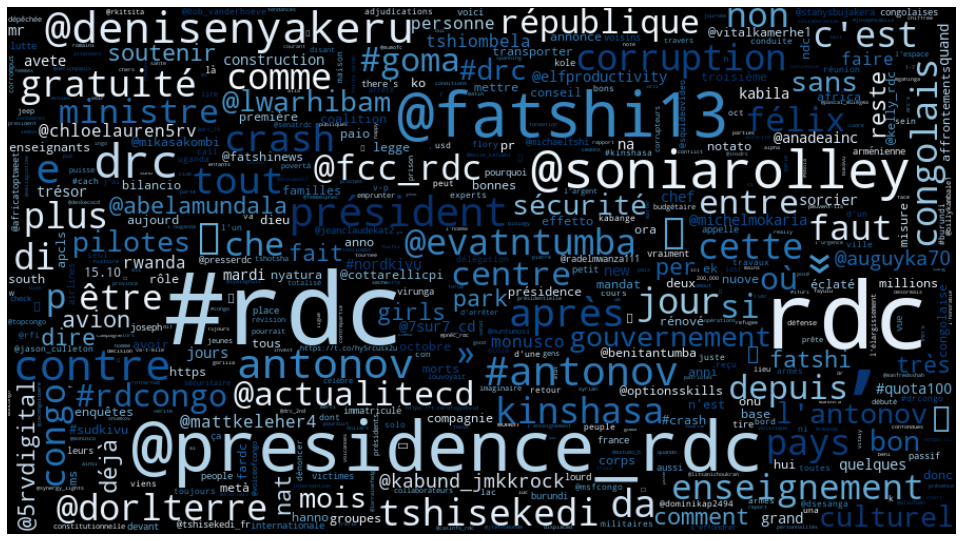

In [25]:
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us try to create a color map with DRC flag to make the wordcount made with DRC colors to see what will happen.

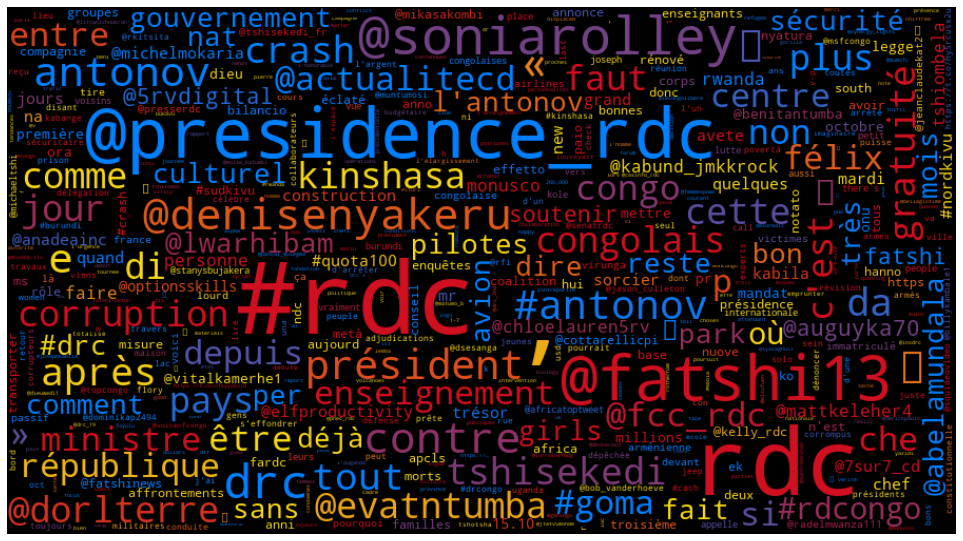

In [26]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap=drc_flag_color_map,normalize_plurals=True).generate_from_frequencies(term_counts)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### V. Improvement on twitter preprocessing 

In [27]:
import re
import preprocessor as tweet_preprocessor
import unicodedata
import many_stop_words

As you can see from the wordcount we find meaningless words, ie (c'est, different word counts for a word with hashtag and without hashtag, twitter handles(Idon't know yet if I should remove them or not))
We can use the approachs form [this blogpost](https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf) to refractor our cleaning process.
- the first approach was to use a thrid part libary to clean the tweet. all the cleaning process are done in background with that libray. The library is called : *[tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/)*
- the second approach was to use additional steps after the normal prepocessin we didd, those steps are (emoji removals, replacing consecutives ascii char with spaces)f
- another prepocessing approach to do is to consider the fact that we are dealing with french tweets, we need to do some prepocessing due to the complexity of that language.
- I will also remove the # from the hashtags

In [28]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3',
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', '’:'
    ])
emoticons = emoticons_happy.union(emoticons_sad)
# let append emoticons to words_to remove

words_to_remove = set(words_to_remove).union(emoticons)

In [29]:
len(words_to_remove)

438

let remove also the emojis

In [30]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

let us remove also word with less than 2 characteres 

In [31]:
less_than_two_word = re.compile(r"w{1,2}")

In [32]:
def remove_nonlatin(s): 
    """
    remove non ascii character but keep accent
    """
    s = (ch for ch in s
         if unicodedata.name(ch).startswith(('LATIN', 'DIGIT', 'SPACE')))
    return ''.join(s)

In [33]:
def remove_emoji(text):
    """
    remove the emojis and non ascii char with space from the tweet
    """
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = ' '.join(re.findall(r'[\u0020-\u007F\u00A0-\u00FF\u0100-\u017F\u0180-\u024F]+', text))
    #remove emojis from tweet
    text = emoji_pattern.sub(r'', text)
    return text

Here is the final normalization process:
- remove_using_library
- remove_emoji()
- process_text()
- french_additional_step()

Let do it 

In [34]:
# I decide to keep and hashtags
tweet_preprocessor.set_options(tweet_preprocessor.OPT.URL, 
                               tweet_preprocessor.OPT.EMOJI,
                               tweet_preprocessor.OPT.RESERVED,
                               tweet_preprocessor.OPT.EMOJI, 
                               tweet_preprocessor.OPT.SMILEY,
                               tweet_preprocessor.OPT.NUMBER, 
                               tweet_preprocessor.OPT.MENTION)

- let apply french additionnal step by removing the stops word we have , we will use an addional library
add additional french word in list of word to remove

In [35]:
words_to_remove = words_to_remove.union(set(many_stop_words.get_stop_words('FR')))

In [36]:
words_to_remove = words_to_remove.union({'le', 'la', 'de'})

In [59]:
def get_term_count():
    """
    preporcess and return terms count from a file of tweets.
    Parm :
    path:  string : the path of the tweet files
    return a dictionary of term and the count of they occurences
    """
    term_counts = Counter()
    for tweet in get_tweets('16-10-2019', '17-10-2019'):
        text = tweet_preprocessor.clean(tweet.get('text'))
        text = text.replace('#', '')
        text = remove_emoji(text)
        tokens = process_text(text=text, tokenizer=TweetTokenizer(), words_to_remove=words_to_remove)
        term_counts.update(tokens)
    return term_counts

In [60]:
for tag, count in get_term_count().most_common(15):
    print("{}: {}".format(tag, count))

antonov: 127
«: 80
crash: 71
e: 69
président: 65
da: 59
kinshasa: 57
gratuité: 52
»: 50
goma: 49
pays: 48
c'est: 47
jour: 45
corruption: 44
di: 43


#### Ploting the wordcount graph again.

In [44]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
def generate_word_cloud(term_counts, color_map):
    return WordCloud(width=900,
                     height=500,
                     max_words=500,
                     max_font_size=100,
                     relative_scaling=0.5,
                     colormap=color_map,
                     normalize_plurals=True).generate_from_frequencies(term_counts)
def plot_word_cloud(word_cloud):
    plt.figure(figsize=(17,14))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.savefig('../images/DRC_WORD_COUNT.png')
    plt.axis("off")
    plt.show()

In [45]:
term_counts['ebola'] = term_counts['ebola']+ term_counts['ébola']

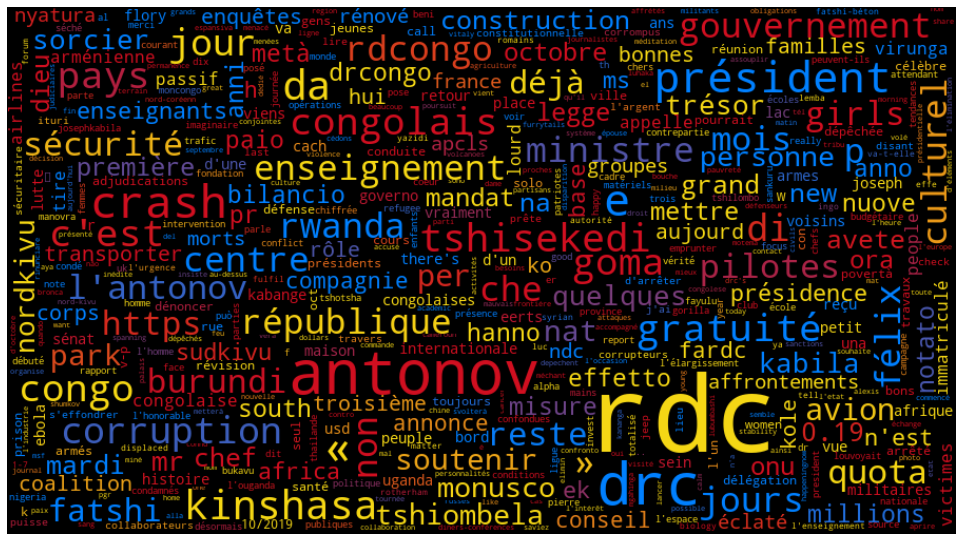

In [47]:
term_counts = get_term_count()
word_cloud = generate_word_cloud(term_counts, drc_flag_color_map)
plot_word_cloud(word_cloud)

In [48]:
len(term_counts)

4894

#### VI. TWITTER TOPIC MODELING

In [50]:
#Uncomment next line to download french stematiser
#! python -m spacy download fr_core_news_sm
#! python -m spacy download fr

     |████████████████████████████████| 13.1MB 168kB/s eta 0:00:01
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.1.0-cp36-none-any.whl size=13156211 sha256=4581589918be47775969507908a68ecf16480fd53445ea902974f016dfc4b646
  Stored in directory: /private/var/folders/qf/c8z68_kd36b91ph15ffxr6zm0000gn/T/pip-ephem-wheel-cache-70yq6dzf/wheels/ab/82/2a/61dd0ff02e22f10eef65a5aa35453a0eb745c84b4c874b612f
Successfully built fr-core-news-sm
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/Users/espoir_mur/Projects/Personnal/Twitter-Analysis-For-DRC/.venv/lib/python3.6/site-packages/fr_core_news_sm
-->
/Users/espoir_mur/Projects/Personnal/Twitter-Analysis-For-DRC

In [51]:
import spacy
from io import BytesIO
from csv import writer 
from datetime import datetime
french_stematiser = spacy.load('fr')

Basically in this phase we wil train a machine learning model on our tweet to see which topics congoleses are talking about.

we will use co-occurence of word in a tweets , if word always appear together they form a topic.

We will use also the score of a word in a given topic to find the most relevants words in a given topic.

We wiil add another preprossesing step called stemming , stemming :
    
In the next step we stem the words in the list. This is essentially where we knock the end off the words. We do this so that similar words will be recognised as the same word by the algorithm

let try spacy for stematisation.

In [52]:
#!pip install -U spacy

In [53]:
def stematise_token(tokens):
    """
    replace word in token list  with his lemma:
    example : appelais  will become appele, plural will be replaced by their singular version, etc
    """

    doc = french_stematiser(' '.join(tokens))
    return [token.lemma_ for token in doc]

let us remove other words we may find in the tweets such as congo, congolais, rdc, drc since we already knows that those words are related to congo

In [54]:
congo_words = {'congo', 'congolais', 'rdc', 'drc', '-', 'https', 'rdc', 'rdcongo', 'drc', 'drcongo', 'tshisekedi'}
words_to_remove = words_to_remove.union(congo_words)

In [61]:
def prepocess_tweet(tweet):
    """
    Apply all the preprocessing process on a tweet and return the tweet as a text and tweet as list of tokens
    
    """
    text = tweet_preprocessor.clean(tweet.get('text'))
    text = text.replace('#', '')
    text = text.replace('-', '')
    text = text.replace("«", "")
    text = text.replace("»", "")
    text = text.replace("_", "")
    text = re.sub(r"\b\w{1}\b", "",text)
    text = re.sub(r"\b\w{2}\b", "",text)
    text = remove_emoji(text)
    tokens = process_text(text=text, tokenizer=TweetTokenizer(), words_to_remove=words_to_remove)
    tokens = stematise_token(tokens)
    return tokens

In [57]:
# the bellow function is not working but it's the most optimal https://stackoverflow.com/a/48287388/4683950 
def create_cleaned_df(output_path):
    """
    take an input file name of tweets , 
    cleaned them write them in a csv file and return a dataframe of cleaned tweets
    """
    output = BytesIO()
    csv_writer = writer(output)

    for tweet in get_tweets('16-10-2019', '17-10-2019'):
        csv_writer.writerow(tweet)
    output.seek(0) # we need to get back to the start of the BytesIO
    df = pd.read_csv(output)
    df.to_csv(output_path=output)
    return df

In [62]:
now = datetime.now()
today = now.strftime("%d-%m-%Y-%H-%M")
output_file_name='../data/cleanned_tweets_{}.csv'.format(today)
tweets_df = pd.DataFrame(columns=['cleanned_tweet'])
for tweet in get_tweets('16-10-2019', '17-10-2019'):
    tweets_df.loc[tweet.get('id')] = [' '.join(prepocess_tweet(tweet))]
tweets_df.to_csv(output_file_name)

In [63]:
tweets_df = pd.read_csv(output_file_name)

In [64]:
print(output_file_name)

../data/cleanned_tweets_16-10-2019-13-31.csv


In [65]:
#tweets_df = create_cleaned_df('../data/query_drc.jsonl', '../data/cleanned_tweets.csv')

In [66]:
tweets_df.set_index('Unnamed: 0', inplace=True)

In [67]:
tweets_df.dropna(inplace=True)

The next step will be to apply now the algorithm and do topic modeling 

#### VI.b. sklearn phase 

To turn the text into a matrix*, where each row in the matrix encodes which words appeared in each individual tweet. We will also filter the words max_df=0.95 means we discard any words that appear in >90% of tweets. In this dataset I don’t think there are any words that are that common but it is good practice. We will also filter words using min_df=5, so words that appear in less than 25 tweets will be discarded. We discard high appearing words since they are too common to be meaningful in topics. We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [69]:
vectorizer = CountVectorizer(max_df=0.95, min_df=5, token_pattern='\w+|\$[\d\.]+|\S+')
transfromed_tweets = vectorizer.fit_transform(tweets_df.get('cleanned_tweet'))

In [70]:
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [71]:
number_of_topics = 5
topic_modeling_model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0, max_iter=200) 

In [72]:
topic_modeling_model.fit(transfromed_tweets)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=200,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [73]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [74]:
no_top_words = 10
display_topics(topic_modeling_model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,antonov,63.2,jour,36.6,antonov,95.2,corruption,32.0,président,49.1
1,avion,31.2,girl,30.2,crash,65.5,park,27.2,non,40.2
2,octobre,26.2,che,27.7,soutenir,30.2,nat,27.2,dire,30.2
3,.,25.2,mort,26.2,enseignement,29.2,fatshi,25.2,congolais,24.0
4,jour,24.7,million,25.2,gratuité,29.1,dieu,23.2,déjà,23.2
5,south,22.2,centre,24.9,pilote,28.2,pays,20.6,école,23.2
6,premier,21.9,avete,24.2,tshiombela,26.2,sécurité,18.2,goma,23.0
7,..,21.2,per,23.6,sorcier,25.2,virunger,17.2,aujourd,21.5
8,ek72903,21.2,pouvoir,23.5,nordkivu,21.2,base,16.2,enseignant,21.2
9,immatriculer,18.2,ora,23.2,présidence,21.2,urgence,16.2,chef,20.6


### let us visualize the results

In [76]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(topic_modeling_model, transfromed_tweets, vectorizer, mds='tsne')
panel

/Users/espoir_mur/Projects/Personnal/Twitter-Analysis-For-DRC/.venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
4      64.420197 -175.956665       1        1  21.422190
0     -59.825794  -87.417450       2        1  20.033281
1      59.776352  -87.386124       3        1  19.912758
3       2.267088  -19.865202       4        1  19.887825
2     -27.112127 -169.579727       5        1  18.743946, topic_info=    Category        Freq          Term       Total  loglift  logprob
48   Default  147.000000       antonov  147.000000  30.0000  30.0000
170  Default   66.000000         crash   66.000000  29.0000  29.0000
456  Default   37.000000           non   37.000000  28.0000  28.0000
639  Default   28.000000      soutenir   28.000000  27.0000  27.0000
76   Default   29.000000         avion   29.000000  26.0000  26.0000
281  Default   29.000000          girl   29.000000  25.0000  25.0000
230  Default   45.000000  enseignement   45.000000  24.0000  24.0000
165  Default   41.000000    corruption   41.000000  23.0000  23.0000
191  Default   28.000000          dire   28.000000  22.0000  22.0000
339  Default   75.000000          jour   75.000000  21.0000  21.0000
697  Default   25.000000    tshiombela   25.000000  20.0000  20.0000
520  Default   29.000000        pilote   29.000000  19.0000  19.0000
493  Default   25.000000          park   25.000000  18.0000  18.0000
446  Default   25.000000           nat   25.000000  17.0000  17.0000
435  Default   25.000000          mort   25.000000  16.0000  16.0000
635  Default   24.000000       sorcier   24.000000  15.0000  15.0000
422  Default   24.000000       million   24.000000  14.0000  14.0000
560  Default   71.000000     président   71.000000  13.0000  13.0000
1    Default   23.000000             .   23.000000  12.0000  12.0000
118  Default   31.000000           che   31.000000  11.0000  11.0000
74   Default   23.000000         avete   23.000000  10.0000  10.0000
291  Default   48.000000      gratuité   48.000000   9.0000   9.0000
481  Default   22.000000           ora   22.000000   8.0000   8.0000
364  Default   22.000000         legge   22.000000   7.0000   7.0000
189  Default   21.000000          dieu   21.000000   6.0000   6.0000
471  Default   30.000000       octobre   30.000000   5.0000   5.0000
114  Default   33.000000        centre   33.000000   4.0000   4.0000
87   Default   21.000000      bilancio   21.000000   3.0000   3.0000
415  Default   21.000000          metà   21.000000   2.0000   2.0000
489  Default   21.000000          paio   21.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
504   Topic5   15.980209        passif   16.715430   1.6293  -4.6313
379   Topic5   15.980209         lourd   16.715430   1.6293  -4.6313
419   Topic5   15.050109     militaire   15.786331   1.6265  -4.6912
509   Topic5   15.049095        people   15.786335   1.6265  -4.6913
141   Topic5   14.120140     condamner   14.857245   1.6234  -4.7550
208   Topic5   13.192952    délégation   13.928183   1.6201  -4.8229
357   Topic5   12.263878           kol   12.999101   1.6161  -4.8960
143   Topic5   12.263878      conduire   12.999101   1.6161  -4.8960
205   Topic5   12.263878       défense   12.999101   1.6161  -4.8960
145   Topic5   12.263003      conflict   12.999104   1.6160  -4.8960
454   Topic5   11.331780           nom   12.069970   1.6112  -4.9750
502   Topic5   10.405704         party   11.140936   1.6060  -5.0603
273   Topic5   10.404961          féli   11.140923   1.6060  -5.0603
266   Topic5    9.476632         forum   10.211853   1.5996  -5.1538
653   Topic5    9.476632        syrian   10.211853   1.5996  -5.1538
271   Topic5    9.476632        fulfil   10.211853   1.5996  -5.1538
193   Topic5    9.476632     displaced   10.211853   1.5996  -5.1538
317   Topic5    9.476632          ingo   10.211853   1.5996  -5.1538
170   Topic5   60.874751         crash   66.811335   1.5812  -3.2938
520   Topic5   26.234198        pilote 

In [77]:
topic_model_nmf = NMF(n_components=5, random_state=0, alpha=.1, l1_ratio=.5)

In [78]:
topic_model_nmf.fit(transfromed_tweets)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=5, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [79]:
no_top_words = 10
display_topics(topic_model_nmf, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,antonov,4.3,quota,1.2,park,2.3,jour,2.6,nordkivu,1.4
1,crash,1.1,che,1.2,nat,2.3,gratuité,1.0,sudkivu,1.3
2,avion,0.8,avete,1.1,virunger,1.5,enseignement,1.0,annonce,1.3
3,ek72903,0.8,legge,1.1,rwander,0.8,école,0.9,apcl,1.2
4,south,0.7,ora,1.1,uganda,0.8,goma,0.8,ndc,1.2
5,arménien,0.7,anni,1.1,gorilla,0.8,bon,0.7,affrontement,1.2
6,compagni,0.7,anno,1.1,volcanoe,0.8,trésor,0.7,éclaté,1.2
7,immatriculer,0.7,hanno,1.1,spanning,0.8,pouvoir,0.6,rénover,1.2
8,airline,0.7,paio,1.1,mgahinger,0.8,déjà,0.6,nyatura,1.2
9,pilote,0.7,effetto,1.1,frontièr,0.0,personne,0.6,.,0.1


I think I have something to understand tommorrow moring ,
now I can level up on the others topics